In [1]:
# Importaciones iniciales
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, preprocessing
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

# importar utilidades de muse-lsl
sys.path.append('../muse')
import utils

#importar seaborn para que se vea bonito
import seaborn
%matplotlib inline

## Cargar datos desde muse
Se pueden leer datos del dispositivo y guardarlos en un .csv con la utilidad de `lsl-record.py.` 

Ejemplo: `python stimulus_presentation/generate_Visual_P300.py & python lsl-record.py -d 60`

Un problema de esta utilidad es que espera un canal de eventos (markers). En este ejemplo dicho canal es provisto por generate_Visual_P300.py que es un evento propio del repositorio original

## Cargar datos CSV para entrenamiento
muse-lsl tiene una utilidad propia para cargar los datos de un .csv. Para utilizarla primero se deben guardar los datos bajo el directorio "data/<nombre>" e invocar la función utils.load_data(). La misma leerá todos los .csv bajo el directorio pasado como argumento y devolverá un objeto del tipo mne.raw.

In [2]:
# Carga los datos desde una carpeta. Espera archivos CSV
subject = 1
session = 1

raw_train = utils.load_data('train', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])
#raw.info

Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.


In [3]:
# explorar los datos
%matplotlib auto
raw_train.plot(butterfly=True, group_by='position', show=True);

Using matplotlib backend: Qt4Agg


/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Effective window size : 8.000 (s)


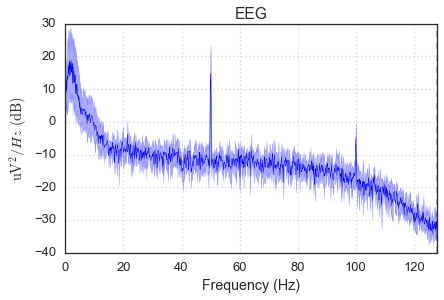

In [4]:
#ver espectro de frecuencia de los EEG
%matplotlib inline
raw_train.plot_psd(color=(0, 0, 1),
          show=False, average=True);

Como puede verse, existe un pico en 50Hz y un armónico en 100Hz.
## Filtrado

Para eliminar información que no necesitamos, filtramos entre 1 y 40Hz

Effective window size : 8.000 (s)
Setting up band-pass filter from 1 - 40 Hz
Effective window size : 8.000 (s)


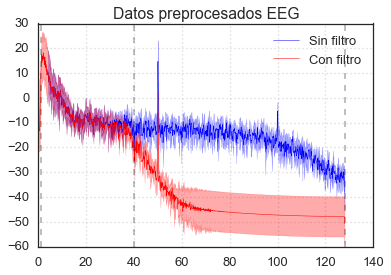

In [5]:
# filtro a 40Hz y grafico el espectro resultante
plt.figure()
ax = plt.axes()
raw_train.plot_psd(tmin=0.0, tmax=20.0, fmin=4.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(0, 0, 1),
          show=False, average=True)

#raw.plot_psd(tmin=0.0, tmax=20.0, fmin=4.0, fmax=40.0, n_fft=2048,
 #            n_jobs=1, proj=True, ax=ax, color=(0, 1, 0),
  #           show=False, average=True)

# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
#filteredRaw  = raw.notch_filter(np.arange(50, 128, 50), n_jobs=1, fir_design='firwin')
filteredRaw = raw_train.filter(1,40, method='iir')
filteredRaw.plot_psd(tmin=0.0, tmax=20.0, fmin=0.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(1, 0, 0),
           show=False, average=True)

ax.set_title('Datos preprocesados EEG')
plt.legend(ax.lines[::3], ['Sin filtro', 'Con filtro'])


## Epoching
Se dividen los registros en Epochs entre -100ms y 800ms luego del evento. No se hace corrección a la baseline y NO se rechazan los eventos mayores a 100uV (mayormente parpadeos) porque es lo que se quiere clasificar.

In [6]:
# descubrir eventos desde el EEG crudo
from mne import Epochs, find_events

events = find_events(raw_train, output='offset')
#elimino el último porque puede quedar cortado
events = events[:-1] 
event_id = {'No papadeo':1,'Parpadeo': 2}
# start of each epoch (400ms before the trigger)
tmin = -0.4    
# end of each epoch (800ms after the trigger)
tmax = 0.8
#normalmente la función de abajo toma otro comando reject = {eeg=some_value} para eliminar los epochs con ruido.
epochs_train = Epochs(raw_train, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose=True)#, picks=[0,1,2,3])
# incidentalmente, existe una función que encuentra automáticamente los artefactos del parpadeo
# pero requiere canales extra que indiquen cuando fue el artefacto.
#eog_events = preprocessing.find_eog_events(raw)

17 events found
Events id: [1 2]
16 matching events found
0 projection items activated
Loading data for 16 events and 308 original time points ...
0 bad epochs dropped


Using matplotlib backend: Qt4Agg
Dropped 2 epochs
Channels marked as bad: []


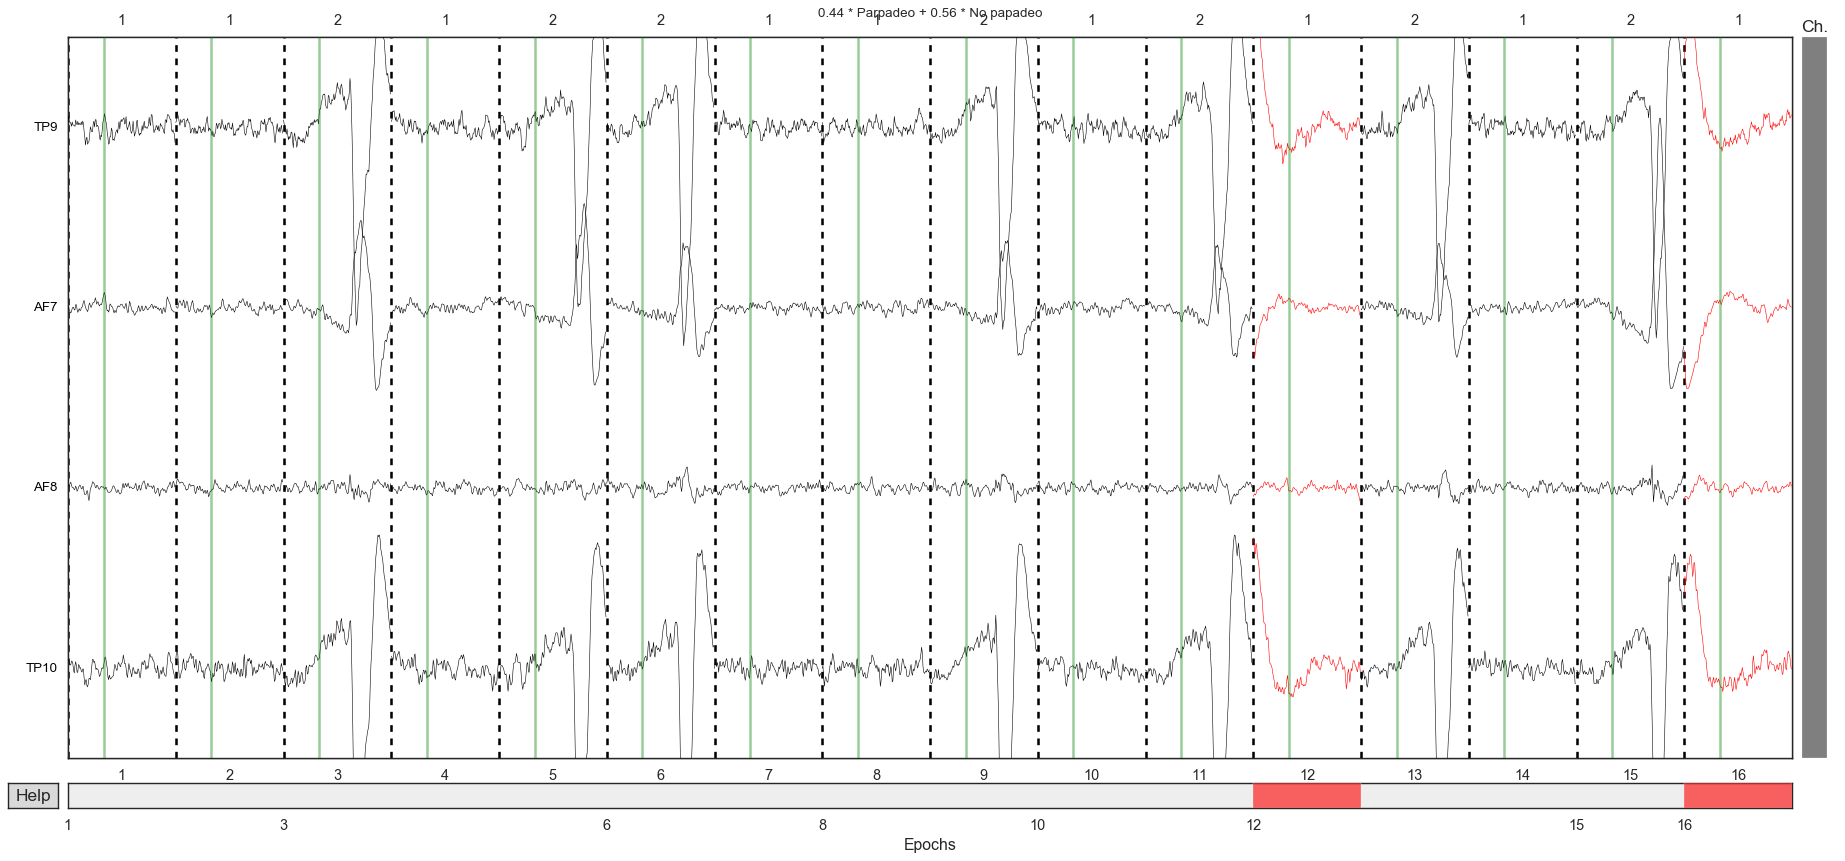

In [7]:
#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib auto 
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
epochs_train.plot(block=True)

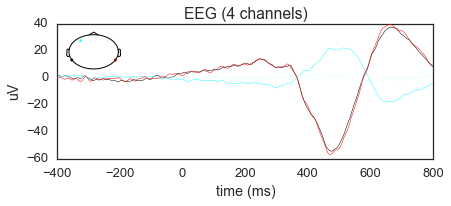

In [8]:
#ver promedios de cada canal
%matplotlib inline
epochs_train.average().plot(spatial_colors=True);

En la figura anterior se muestra el promedio de los Epochs para los cuatro canales. Este sería el "patron" a detectar si sólo trabajamos en el dominio del tiempo. Se observa que el patrón bastante evidente. En la figura donde se ven los valores instantáneos de los Epochs se puede apreciar que los identificados como 1 y 2 no presentan la misma figura que los otros. Habrá pues que excluirlos.

In [14]:
# borrar los dos primeros, 
#epochs.drop([0,1])

Dropped 2 epochs


<Epochs  |  n_events : 9 (all good), tmin : -0.3984375 (s), tmax : 0.80078125 (s), baseline : None, ~129 kB, data loaded>

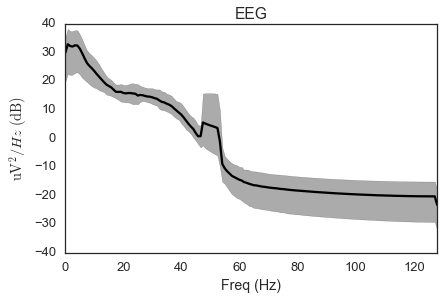

In [10]:
epochs_train.plot_psd(area_mode='range', tmax=10.0, show=False);
#raw.plot_projs_topomap()

#  Clasificación

En el contexto de EEG, al aprendizaje supervisado se le llama _decoding_ o también _multivariate pattern analysis (MPVA)_ 


In [11]:
#imports
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import Vectorizer, get_coef

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


# import a linear classifier from mne.decoding
from mne.decoding import LinearModel

In [13]:
labels = epochs_train.events[:, -1]

## Entrenamiento

En primer lugar hay que escalar los datos. Al aplicar el scaler, el dataset queda con media cero y desviación estandar unitaria. Esto es necesario porque muchos métodos de ML asumen que así se presentarán los datos.


In [14]:
clf = LogisticRegression()
scaler = StandardScaler()

# create a linear model with LogisticRegression
model = LinearModel(clf)

#reshape data
eeg_data_train = epochs_train.get_data().reshape(len(labels), -1)
# fit the classifier on MEG data
X = scaler.fit_transform(eeg_data_train)
model.fit(X, labels)

LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

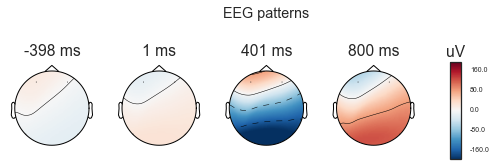

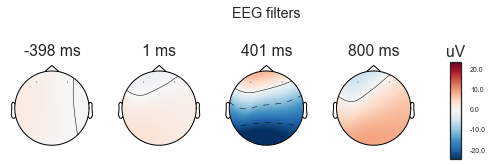

In [16]:
# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs_train.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs_train.info, tmin=epochs_train.tmin)
    evoked.plot_topomap(title='EEG %s' % name)


Esto que viene a continuación es lo mismo pero de otra manera. Notar que los gráficos producidos son idénticos. Estaría bueno estudiar si hay alguna diferencia real.

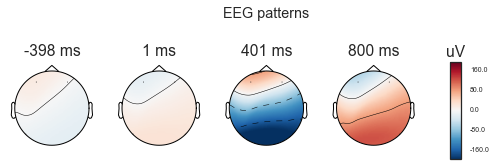

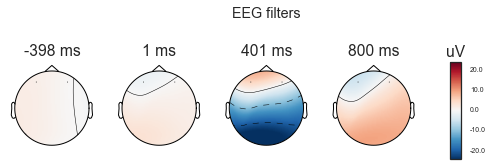

In [17]:
X = epochs_train.pick_types(meg=False, eeg=True)
y = epochs_train.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    LinearModel(LogisticRegression()))  # 3) fits a logistic regression
clf.fit(X, y)

# Extract and plot patterns and filters
for name in ('patterns_', 'filters_'):
    # The `inverse_transform` parameter will call this method on any estimator
    # contained in the pipeline, in reverse order.
    coef = get_coef(clf, name, inverse_transform=True)
    evoked = EvokedArray(coef, epochs_train.info, tmin=epochs_train.tmin)
    evoked.plot_topomap(title='EEG %s' % name[:-1])

array([1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2])

## Performance
A continuación con el modelo ya entrenado, vamos a verificar que el mismo puede predecir si un evento se trata de un parpadeo o no con un dataset de pruebas, distinto al usado.

In [19]:
subject = 1
session = 1

raw_test = utils.load_data( 'test', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])

Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.


Effective window size : 8.000 (s)
Setting up band-pass filter from 1 - 40 Hz
Effective window size : 8.000 (s)


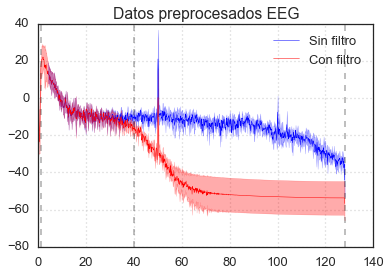

In [20]:
# filtro a 40Hz y grafico el espectro resultante
plt.figure()
ax = plt.axes()
raw_test.plot_psd(tmin=0.0, tmax=20.0, fmin=4.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(0, 0, 1),
          show=False, average=True)

#raw.plot_psd(tmin=0.0, tmax=20.0, fmin=4.0, fmax=40.0, n_fft=2048,
 #            n_jobs=1, proj=True, ax=ax, color=(0, 1, 0),
  #           show=False, average=True)

# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
#filteredRaw  = raw.notch_filter(np.arange(50, 128, 50), n_jobs=1, fir_design='firwin')
filteredRaw = raw_test.filter(1,40, method='iir')
filteredRaw.plot_psd(tmin=0.0, tmax=20.0, fmin=0.0, fmax=128.0, n_fft=2048,
           n_jobs=1, proj=False, ax=ax, color=(1, 0, 0),
           show=False, average=True)

ax.set_title('Datos preprocesados EEG')
plt.legend(ax.lines[::3], ['Sin filtro', 'Con filtro'])

14 events found
Events id: [1 2]
14 matching events found
0 projection items activated
Loading data for 14 events and 308 original time points ...
1 bad epochs dropped
Using matplotlib backend: Qt4Agg


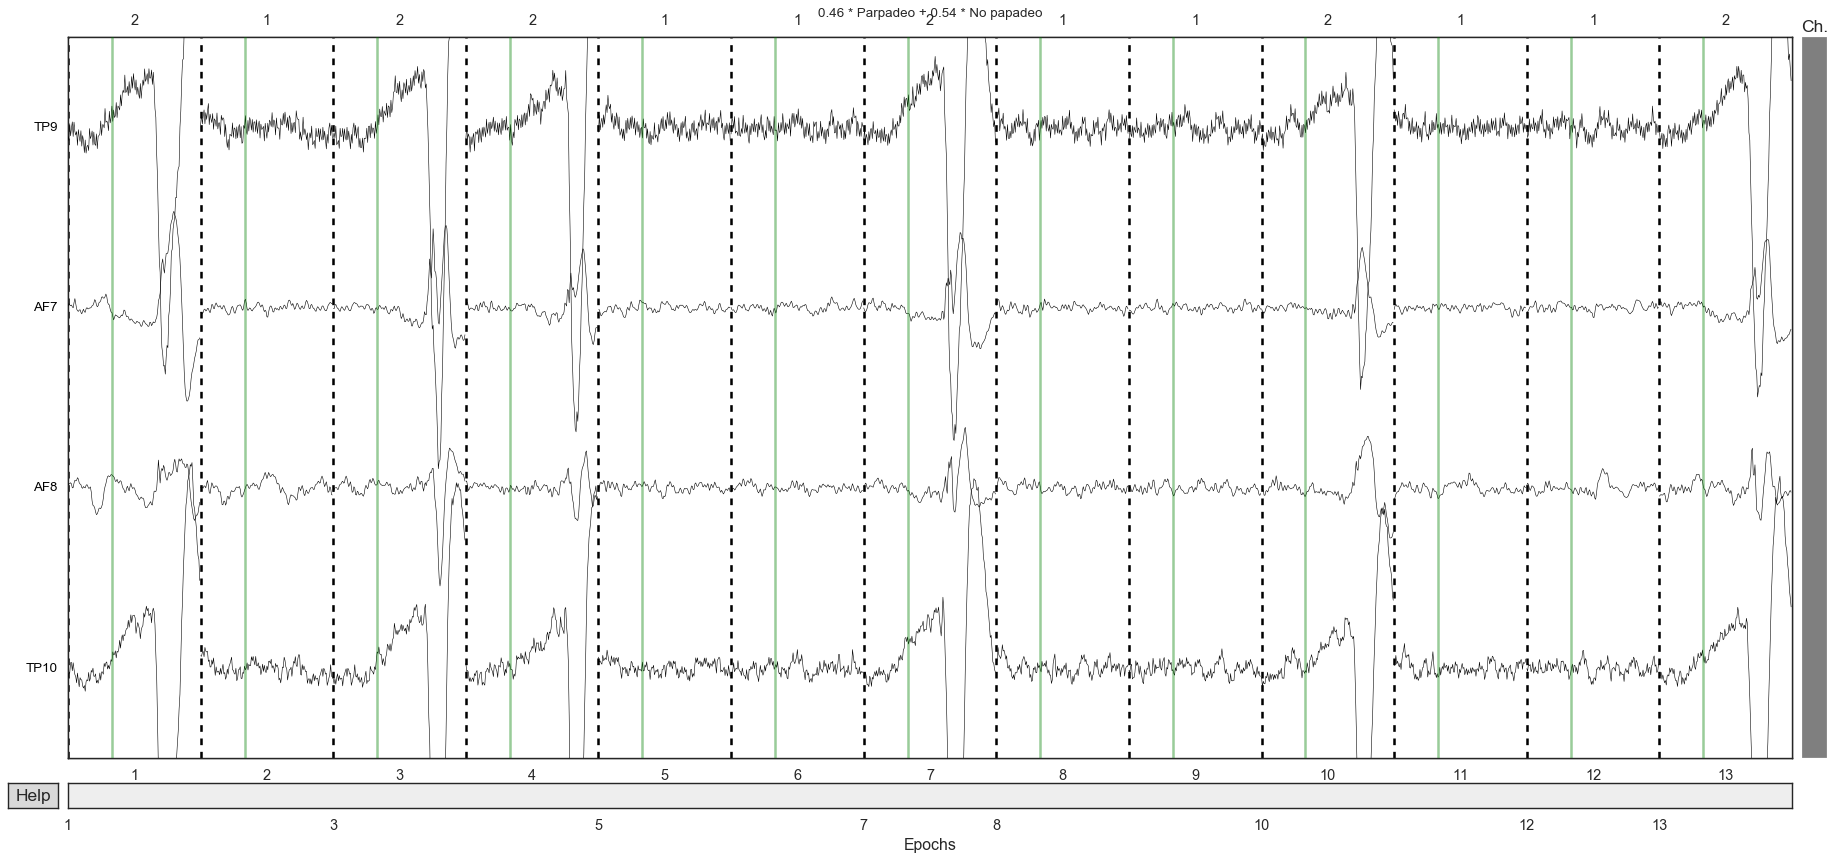

Dropped 0 epochs
Channels marked as bad: []


In [24]:
# descubrir eventos desde el EEG crudo
events_test = find_events(raw_test, output='offset')
#elimino el último porque puede quedar cortado
#events_test = events[:-1] 
event_id = {'No papadeo':1,'Parpadeo': 2}
# start of each epoch (400ms before the trigger)
tmin = -0.4    
# end of each epoch (800ms after the trigger)
tmax = 0.8
#normalmente la función de abajo toma otro comando reject = {eeg=some_value} para eliminar los epochs con ruido.
epochs_test = Epochs(raw_test, events=events_test, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True, verbose=True)#, picks=[0,1,2,3])

#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib auto 
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
epochs_test.plot(block=True, show=True)

In [35]:
X_test = epochs_test.pick_types(meg=False, eeg=True)
y_test = epochs_test.events[:, 2]


In [28]:
X_test

<Epochs  |  n_events : 13 (all good), tmin : -0.3984375 (s), tmax : 0.80078125 (s), baseline : None, ~144 kB, data loaded,
 'No papadeo': 7, 'Parpadeo': 6>

In [33]:
len(y)

14

In [30]:
y_predicted = clf.predict(X_test)

In [36]:
np.equal(y_test, y_predicted)

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [34]:
len(y_predicted
)

13

# TODO
- TODO Evoked
- TODO mne.set_eeg_reference (incluir referencia para mejorar SNR?)
- TODO ICA Preprocessing for artifact supression
- TODO Epoching on the fly